Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Recommended Properties:
         zpid            city state     price  bedrooms  bathrooms
14   25048592         Fremont    CA  950000.0         2          1
8   242994717            Sula    MT  345000.0         1          1
12   89566253  Bonita Springs    FL  550000.0         3          2
0    79253961      Petersburg    VA  217900.0         3          1
17   12323689         Henrico    VA  210000.0         3          1


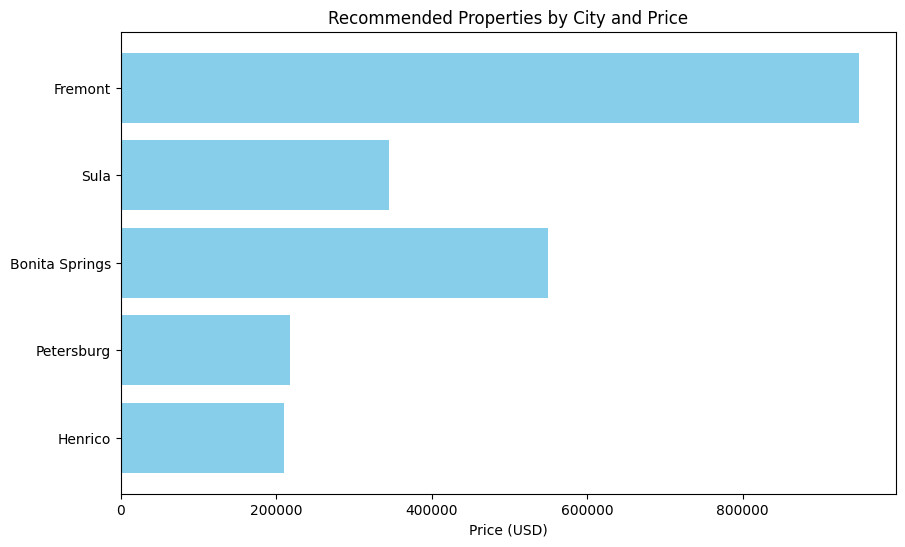

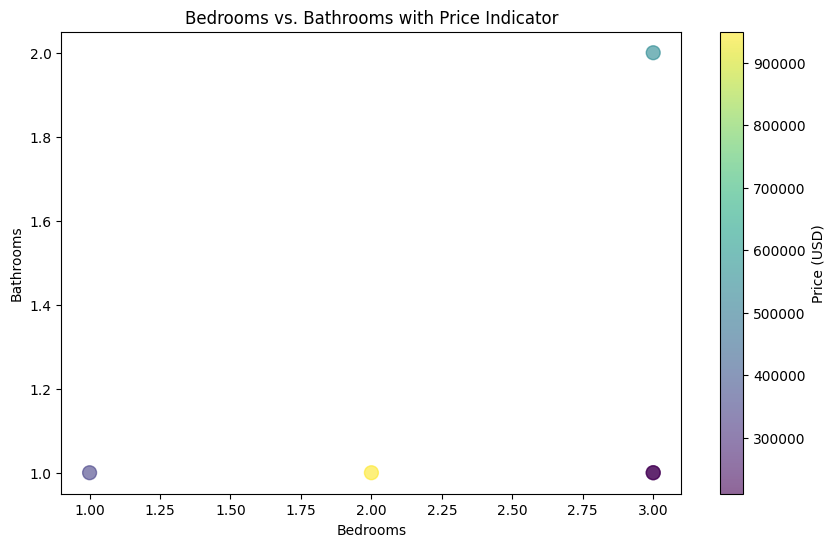

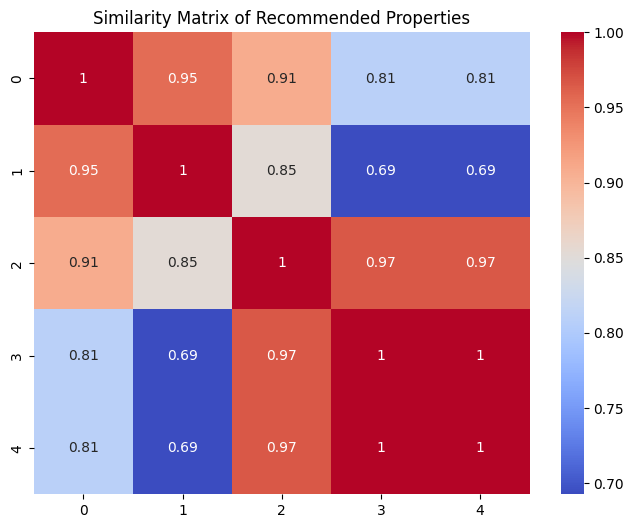

In [ ]:
# 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from google.colab import drive

# 2: Load the Data
drive.mount('/content/drive')
df = pd.read_csv('/content/Properties.csv')  # Adjust path if necessary
df.head()

# 3: Data Preparation
# Clean and convert the price column
df['price'] = df['price'].str.replace('USD ', '', regex=False).str.replace(',', '', regex=False).astype(float)

# Select relevant features and handle any missing values
features = df[['bedrooms', 'bathrooms', 'price']].fillna(0)

# Standardize features for similarity calculation
features_scaled = StandardScaler().fit_transform(features)
cosine_sim = cosine_similarity(features_scaled)  # Calculate cosine similarity matrix

# Define a function to get property recommendations
def get_recommendations(zpid, cosine_sim, df, n_recommendations=5):
    try:
        index = df.index[df['zpid'] == zpid].tolist()[0]  # Get property index
    except IndexError:
        print("ZPID not found in the dataset.")
        return pd.DataFrame(), []

    # Sort by similarity, excluding the property itself
    sim_scores = sorted(list(enumerate(cosine_sim[index])), key=lambda x: x[1], reverse=True)
    recommended_indices = [i[0] for i in sim_scores[1:n_recommendations + 1]]
    return df.iloc[recommended_indices], recommended_indices

# Example usage
property_id = 20551023  # Replace with a valid ZPID
recommended_properties, recommended_indices = get_recommendations(property_id, cosine_sim, df, n_recommendations=5)

# 4: Display Recommendations and Visualize
if not recommended_properties.empty:
    print("Recommended Properties:")
    print(recommended_properties[['zpid', 'city', 'state', 'price', 'bedrooms', 'bathrooms']])

    # Visualization 1: Horizontal Bar Chart of Recommended Properties' Prices
    plt.figure(figsize=(10, 6))
    plt.barh(recommended_properties['city'], recommended_properties['price'], color='skyblue')
    plt.xlabel('Price (USD)')
    plt.title('Recommended Properties by City and Price')
    plt.gca().invert_yaxis()
    plt.show()

    # Visualization 2: Scatter Plot of Bedrooms vs. Bathrooms with Price Color Map
    plt.figure(figsize=(10, 6))
    plt.scatter(recommended_properties['bedrooms'], recommended_properties['bathrooms'],
                c=recommended_properties['price'], cmap='viridis', s=100, alpha=0.6)
    plt.colorbar(label='Price (USD)')
    plt.xlabel('Bedrooms')
    plt.ylabel('Bathrooms')
    plt.title('Bedrooms vs. Bathrooms with Price Indicator')
    plt.show()

    # Visualization 3: Heatmap of Cosine Similarity Matrix for the Recommendations
    plt.figure(figsize=(8, 6))
    sns.heatmap(cosine_sim[np.ix_(recommended_indices, recommended_indices)], cmap='coolwarm', annot=True, cbar=True)
    plt.title("Similarity Matrix of Recommended Properties")
    plt.show()
else:
    print("No recommendations to display.")